# Galaxy Morphology Classification with Swin Transformer (Tiny)

### This notebook demonstrates galaxy morphology classification using a Swin Transformer (Tiny) model. It includes data loading and augmentation, stratified train/validation/test splits, custom PyTorch dataset and dataloaders, model definition and training with mixed-precision and AdamW optimizer, and evaluation using confusion matrices and classification reports. The workflow provides an end-to-end deep learning pipeline for image-based galaxy classification.

## Device Setup

In [ ]:
import torch
# Check if CUDA is available and set the device accordingly

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Supress Warnings

In [ ]:
import warnings
# Supress Unwanted Warnings
warnings.filterwarnings("ignore")


## Install Dependencies

In [ ]:
!pip install astroNN
# Installs the astroNN package, required for dataset loading


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.9 MB/s eta 0:00:00


## Import Libraries

In [ ]:
# Imports all necessary libraries for data handling, model building, training, and evaluation
import time
import os
import random
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T

import torch.nn as nn
from torchvision import models

import torch.optim as optim
from torch.cuda import amp

from astroNN.datasets import load_galaxy10
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight


## Load Dataset

In [5]:
images, labels = load_galaxy10()
y = labels.astype(np.int64)
X = images
print("X:", X.shape, X.dtype, " y:", y.shape, y.dtype)

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [06:00<00:00, 9.68MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [06:08, 7.42MB/s]                            


X: (17736, 256, 256, 3) uint8  y: (17736,) int64


## Class Mappings and Visualizations

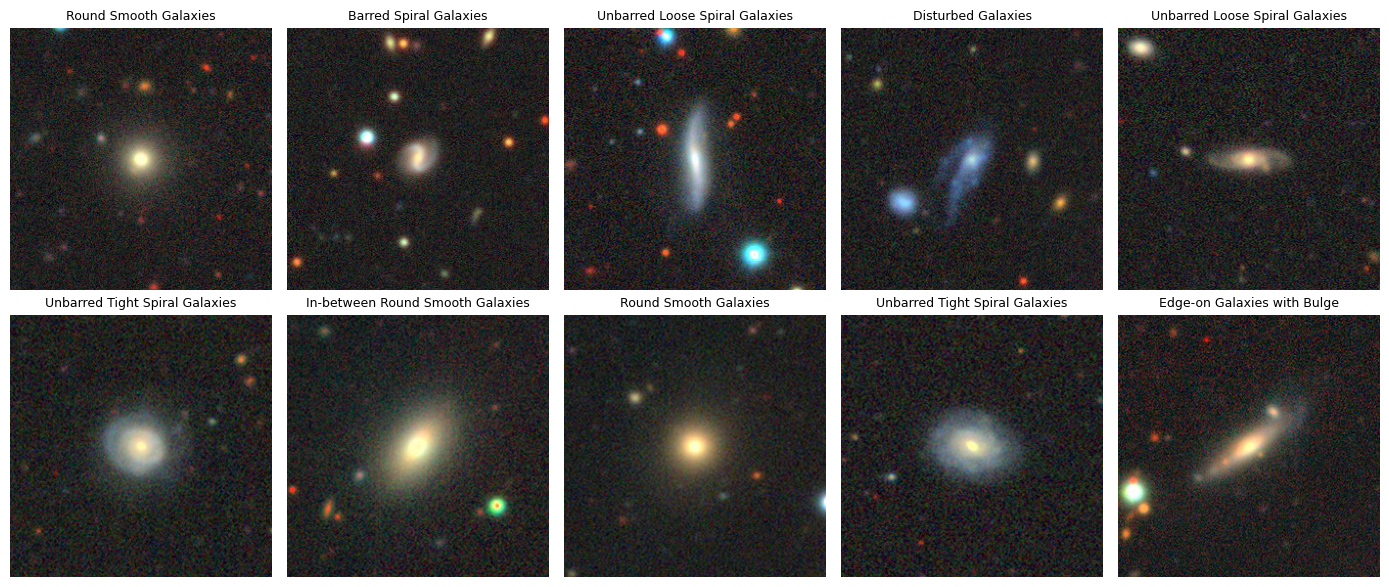

In [6]:

# Class mapping for Galaxy10 DECals
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge",
}

# Plot a few random examples
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for ax in axes.flat:
    idx = np.random.randint(0, len(images))
    ax.imshow(images[idx])
    ax.set_title(class_names[labels[idx]], fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Dataset class (flip + tiny rotate + color jitter + normalize)

In [7]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class GalaxyDecalsDataset(Dataset):
  def __init__(self, images, labels, img_size=(224,224), train=True):
    self.images = images
    self.labels = labels.astype(np.int64)

    if train:
      self.transform = T.Compose([
        T.Resize(img_size, antialias=True),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=5),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
      ])
    else:
      self.transform = T.Compose([
        T.ToTensor(),
        T.Resize(img_size, antialias=True),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
      ])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img = Image.fromarray(self.images[index])
    x = self.transform(img)
    y = torch.tensor(self.labels[index], dtype=torch.long)
    return x, y

## Dataloaders (train/val/test)

In [ ]:


# stratified split 
N = len(images)

# First split: train (70%) vs temp (30%)
train_idx, temp_idx = train_test_split(
    np.arange(N),
    test_size=0.30,
    random_state=42,
    stratify=labels
)

# Second split: val (15%) vs test (15%) from temp
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,  # half of 30% = 15%
    random_state=42,
    stratify=labels[temp_idx]
)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

# build datasets 
train_dataset = Subset(GalaxyDecalsDataset(images, labels, img_size=(224,224), train=True),  train_idx)
val_dataset   = Subset(GalaxyDecalsDataset(images, labels, img_size=(224,224), train=False), val_idx)
test_dataset  = Subset(GalaxyDecalsDataset(images, labels, img_size=(224,224), train=False), test_idx)

# loaders 
BATCH_SIZE   = 64
NUM_WORKERS  = 4
PIN          = torch.cuda.is_available()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN)

# sanity check 
xb, yb = next(iter(train_loader))
print("Batch:", xb.shape, yb.shape, yb.dtype)


Train: 12415, Val: 2660, Test: 2661
Batch: torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.int64


## Model Definition

In [ ]:
# Define the Swin Transformer based model
class SwinGalaxy(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super().__init__()
        m = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = m.head.in_features
        m.head = nn.Identity()
        self.backbone = m
        self.head = nn.Sequential(
            nn.LayerNorm(in_features),
            nn.Linear(in_features, 512), nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        feat = self.backbone(x)      # [B, 768]
        return self.head(feat)       # [B, 10]



Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


100%|██████████| 108M/108M [00:00<00:00, 233MB/s] 


## Model Instantiation

In [21]:
# instantiate Swin Transformer model (Tiny) for 10 classes
model = SwinGalaxy(num_classes=10, pretrained=True).to(device)

# set dropout inside the Swin head to 0.2
for m in model.head:
    if isinstance(m, nn.Dropout):
        m.p = 0.2

# fine-tune everything (no freezing)
for p in model.parameters():
    p.requires_grad = True

print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Trainable params: 27919748


## Loss, Optimizer, Scheduler, AMP

In [ ]:
# Sets up the loss function with class weights to handle class imbalance

weights = compute_class_weight("balanced", classes=np.arange(10), y=labels)
crit = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=device, dtype=torch.float))


# Optimizer (single LR for everything) 
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Scheduler (cosine decay across epochs) 
EPOCHS = 30
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# AMP Scaler (mixed precision if on GPU) 
scaler = torch.cuda.amp.GradScaler(enabled=(torch.cuda.is_available() and str(device) == "cuda"))

## Training and Evaluation Functions

In [ ]:
# Train one epoch 
def train_epoch(model, loader, loss_fn, optimizer, device, scaler):
    model.train()
    train_loss, correct, n = 0.0, 0, 0

    for imgs, y in loader:
        imgs, y = imgs.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(imgs)             # [B, 10]
            loss = loss_fn(logits, y)        # CrossEntropyLoss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # metrics
        bs = y.size(0)
        train_loss += loss.item() * bs
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        n += bs

    avg_loss = train_loss / n
    avg_acc  = correct / n
    return avg_loss, avg_acc


# Evaluate one epoch 
@torch.no_grad()
def eval_epoch(model, loader, loss_fn, device):
    model.eval()
    val_loss, correct, n = 0.0, 0, 0

    for imgs, y in loader:
        imgs, y = imgs.to(device), y.to(device)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(imgs)
            loss = loss_fn(logits, y)

        bs = y.size(0)
        val_loss += loss.item() * bs
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        n += bs

    avg_loss = val_loss / n
    avg_acc  = correct / n
    return avg_loss, avg_acc


## Training Loop

In [ ]:
import time
import torch

# Config 
EPOCHS   = 30
PATIENCE = 10
best_val_loss = float("inf")
patience_counter = 0

best_model_path = "swin_galaxy.pt"

history = {
    "train_loss": [],
    "train_acc":  [],
    "val_loss":   [],
    "val_acc":    [],
}

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # Train 
    train_loss, train_acc = train_epoch(
        model, train_loader, crit, optimizer, device, scaler
    )

    # Validate 
    val_loss, val_acc = eval_epoch(
        model, val_loader, crit, device
    )

    # Scheduler step 
    scheduler.step()

    # Log 
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    dt = time.time() - t0
    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"train_loss {train_loss:.4f} acc {train_acc:.3f} | "
        f"val_loss {val_loss:.4f} acc {val_acc:.3f} | "
        f"{dt:.1f}s"
    )

    # Checkpoint & Early Stop 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history,
            "note": "Swittransformer | CrossEntropyLoss"
        }, best_model_path)
        print("Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best & TEST 
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt["model_state"])

test_loss, test_acc = eval_epoch(model, test_loader, crit, device)

print("\n=== Test Results (best checkpoint) ===")
print(f"Loss: {test_loss:.4f}")
print(f"Acc : {test_acc:.3f}")


Epoch 01/30 | train_loss 1.2562 acc 0.540 | val_loss 0.6622 acc 0.781 | 29.6s
Saved new best model
Epoch 02/30 | train_loss 0.7783 acc 0.737 | val_loss 0.5492 acc 0.824 | 29.4s
Saved new best model
Epoch 03/30 | train_loss 0.6517 acc 0.782 | val_loss 0.5612 acc 0.819 | 29.3s
Epoch 04/30 | train_loss 0.5956 acc 0.799 | val_loss 0.5670 acc 0.820 | 29.1s
Epoch 05/30 | train_loss 0.5367 acc 0.821 | val_loss 0.5059 acc 0.838 | 29.4s
Saved new best model
Epoch 06/30 | train_loss 0.4984 acc 0.834 | val_loss 0.5488 acc 0.835 | 29.2s
Epoch 07/30 | train_loss 0.4432 acc 0.851 | val_loss 0.4800 acc 0.831 | 29.1s
Saved new best model
Epoch 08/30 | train_loss 0.4089 acc 0.859 | val_loss 0.4872 acc 0.842 | 29.3s
Epoch 09/30 | train_loss 0.3956 acc 0.862 | val_loss 0.5217 acc 0.836 | 29.5s
Epoch 10/30 | train_loss 0.3640 acc 0.875 | val_loss 0.4620 acc 0.852 | 29.5s
Saved new best model
Epoch 11/30 | train_loss 0.3272 acc 0.887 | val_loss 0.4874 acc 0.847 | 29.2s
Epoch 12/30 | train_loss 0.3008 acc 0

## Plotting Results

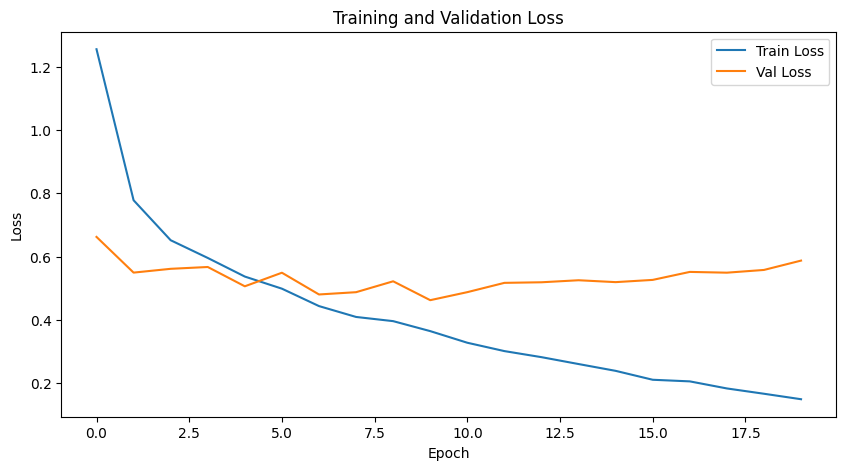

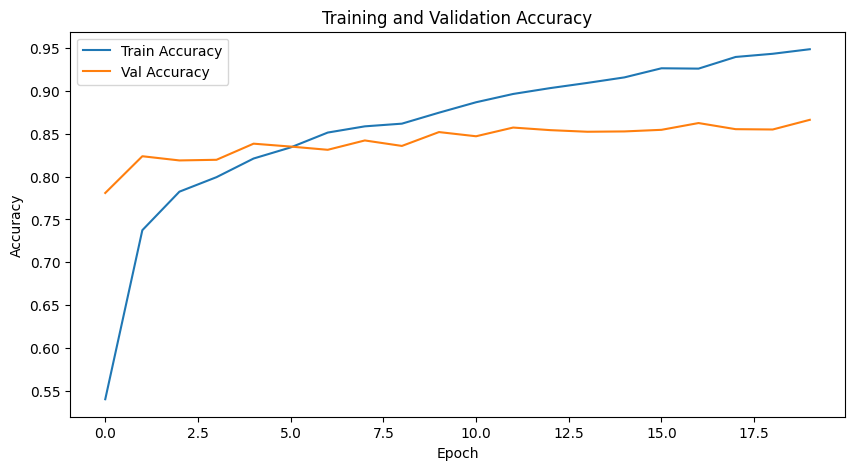

In [ ]:

# Plots training and validation loss and accuracy over epochs

# Plot Loss 
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Accuracy 
plt.figure(figsize=(10, 5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


## Evaluation & Analysis

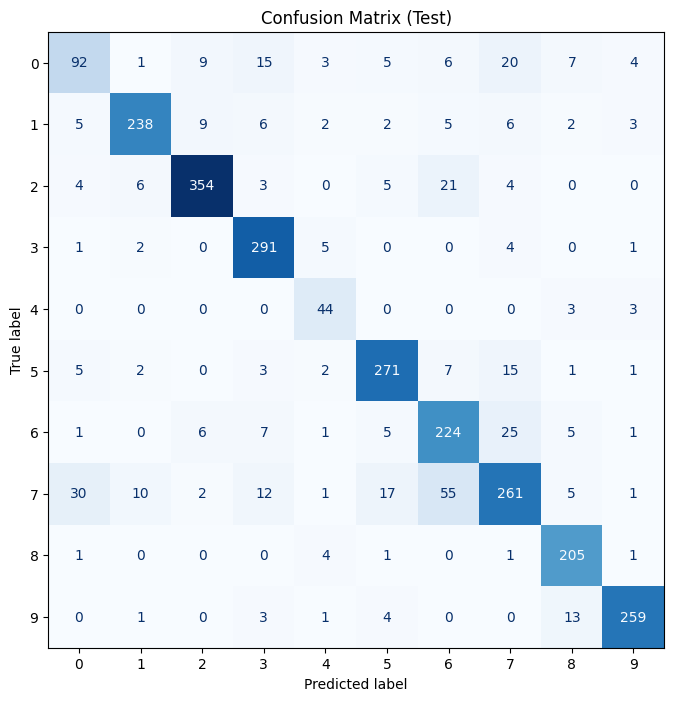


=== Classification Report (per class) ===
              precision    recall  f1-score   support

           0      0.662     0.568     0.611       162
           1      0.915     0.856     0.885       278
           2      0.932     0.892     0.911       397
           3      0.856     0.957     0.904       304
           4      0.698     0.880     0.779        50
           5      0.874     0.883     0.878       307
           6      0.704     0.815     0.755       275
           7      0.777     0.662     0.715       394
           8      0.851     0.962     0.903       213
           9      0.945     0.922     0.933       281

    accuracy                          0.841      2661
   macro avg      0.821     0.840     0.828      2661
weighted avg      0.842     0.841     0.840      2661



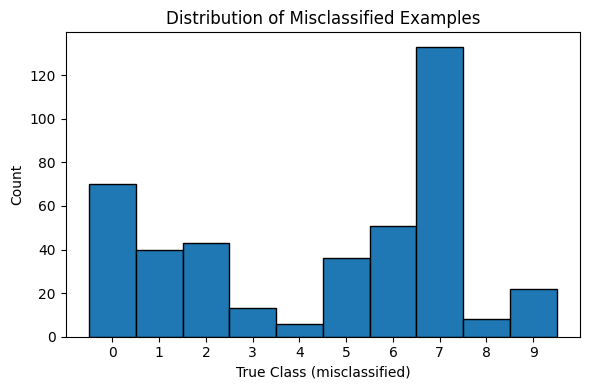

In [ ]:
# Collect predictions and truths (classification) 
def collect_preds(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                logits = model(xb)              # [B, 10]
            preds = logits.argmax(dim=1)        # class indices
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# Get predictions
y_true, y_pred = collect_preds(model, test_loader, device)

# Confusion Matrix 
cm = confusion_matrix(y_true, y_pred, labels=range(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix (Test)")
plt.show()

# Classification Report 
print("\n=== Classification Report (per class) ===")
print(classification_report(y_true, y_pred, digits=3))

# Error Distribution 
errors = y_pred != y_true
plt.figure(figsize=(6,4))
plt.hist(y_true[errors], bins=np.arange(11)-0.5, edgecolor="black")
plt.xticks(range(10))
plt.xlabel("True Class (misclassified)")
plt.ylabel("Count")
plt.title("Distribution of Misclassified Examples")
plt.tight_layout()
plt.show()